In [24]:
# Add DEVENV_PATH to the path so that we can import the modules
import sys
from os import getenv
import numpy as np
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib
import pendulum

cutoff = "2025-01-29T23:35:35.626996+01:00"
cutoff_end = '2025-01-30T00:40:49.052379+01:00'


load_gin(exp_name="ingest-kafka", test=False)
# cutoff_end = pendulum.now().to_iso8601_string()
# cutoff_end


In [25]:
def plot_energy_proportionality(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from matplotlib.ticker import PercentFormatter

    
    # Create plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x='load_pct',
        y='average_power',
        hue='system',
        style='system',
        markers=['o', 's'],
        dashes=False,
        palette={'Kafka': '#1f77b4', 'Redpanda': '#ff7f0e'},
        markersize=8,
        linewidth=2
    )
    
    plt.title('Power Proportionality Comparison', fontsize=14, pad=20)
    plt.xlabel('% of Max Throughput', fontsize=12)
    plt.ylabel('Power Consumption (W)', fontsize=12)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(decimals=0))
    
    load_pcts = [100] + list(range(100, 0, -10))
    plt.xticks(load_pcts)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(title='System', frameon=True, loc='upper left')
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    # return plt.gcf()


In [39]:
def plot_energy_efficiency(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import PercentFormatter, FormatStrFormatter

    # Calculate energy cost (Joules/MB)
    df = df.copy()
    df['average_power'] -= 60
    df['energy_cost'] = df['average_power'] / df['throughput_MBps']  # J/MB
    df['energy_efficiency'] = 1 / df['energy_cost']  # MB/J
    
    # Create plot
    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(
        data=df,
        x='load_pct',
        y='energy_efficiency',
        hue='system',
        style='system',
        markers=['o', 's'],
        dashes=False,
        palette={'Kafka': '#1f77b4', 'Redpanda': '#ff7f0e'},
        markersize=8,
        linewidth=2,
        errorbar='sd'
    )

    plt.title('Energy Efficiency Comparison', fontsize=14, pad=20)
    plt.xlabel('% of Max Throughput', fontsize=12)
    plt.ylabel('Energy Cost (J/MB)\nLower is better', fontsize=12)
    
    # Format axes
    ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Set grid and legend
    plt.grid(True, alpha=0.3, linestyle='--', which='both')
    plt.legend(title='System', frameon=True, loc='upper right')
    
    # # Ensure proper tick spacing
    # load_ticks = np.arange(0, 110, 10)
    # plt.xticks(load_ticks)
    
    # Set intelligent y-axis limits
    # y_min = df['energy_cost'].min() * 0.99
    # y_max = df['energy_cost'].max() * 1.01
    # plt.ylim(y_min, y_max)

    sns.despine()
    plt.tight_layout()
    plt.show()
    # return plt.gcf()


In [29]:
common = dict(
    type="proportionality",
    cutoff_begin=cutoff,
    cutoff_end=cutoff_end,
)
# ovhnvme_1 = an.full_analytical_pipeline(cluster="ovhnvme", **common)
ovhnvme = an.full_analytical_pipeline(cluster="ovhnvme", **common)
# ovhnvme = ovhnvme[["exp_name", "average_power", "started_ts", "load"]]
# Create system labels and ensure correct ordering
system_mapping = {
    'ingest-kafka': 'Kafka',
    'ingest-redpanda': 'Redpanda'
}
# ovhnvme = ovhnvme.copy()
ovhnvme['system'] = ovhnvme['exp_name'].map(system_mapping)

# Create load percentages (0-100% in 10% increments)
load_pcts = list(range(100, 0, -10)) + [100]

# Assign load percentages based on experiment order
ovhnvme['load_pct'] = np.tile(load_pcts, 2)  # Repeat for both systems
an.create_qgrid_widget(ovhnvme)
# Drop all irrelevant columns
# ovhnvme.count()
# taurus_1 = an.full_analytical_pipeline(cluster="o", **common)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

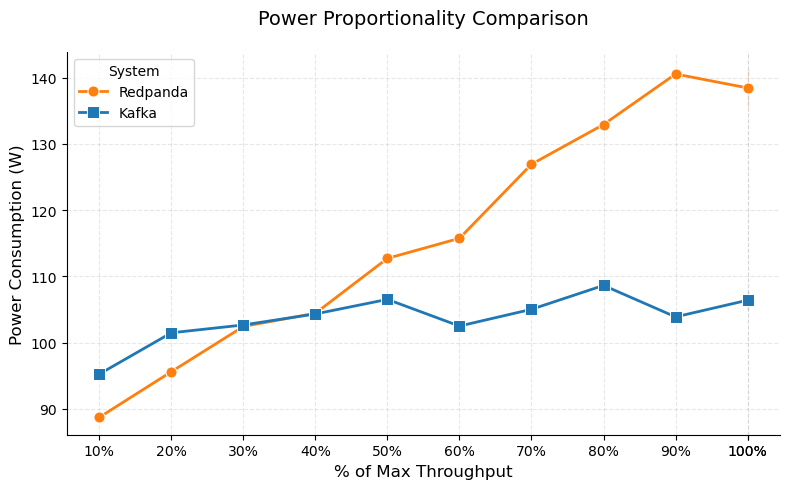

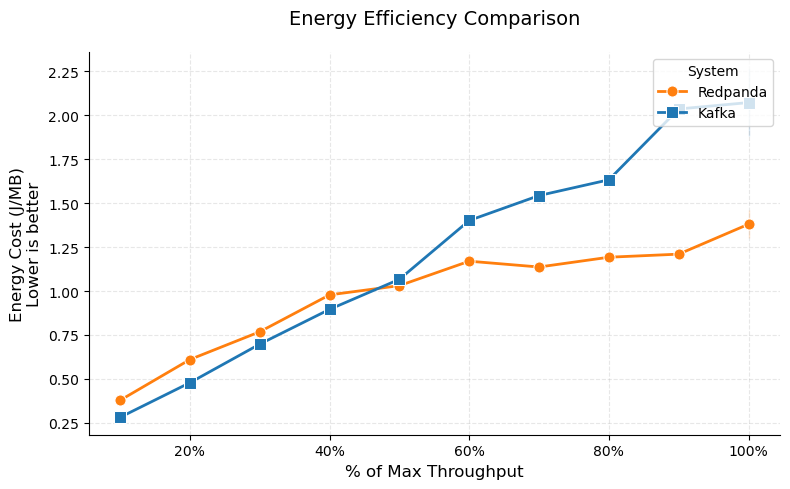

In [40]:
plot_energy_proportionality(ovhnvme)
plot_energy_efficiency(ovhnvme)